# Semi-Supervised Learning (SSL)


SSL studies how to learn from both labeled and unlabeled data, which can be useful when data is abundant but the resources to label them are limited.

In this exercise, you will:

* Given a simulated dataset with both labeled and unlabeled data, build a similarity graph and use the Harmonic Function Solution (HSF) to predict the labels of the unlabeled data;
* Use HSF for face recognition, given a fixed dataset;
* Implement an online version of HSF to label images as they appear in real time.

## 1. Harmonic Function Solution

Let $G = (V, E)$ be a weighted undirected graph where $V = \{x_1, \ldots, x_n \}$ is the vertex set and $E$ is the edge set. Each edge $e_{ij} \in E$ has a weight $w_{ij}$ and, if there is no edge between $x_i$ and $x_j$, then $w_{ij}=0$.

Let $|V| = n$ be the total number of nodes. Only a subset of the nodes $S \subset V$ with cardinality $|S| = l$ is labeled, and the remaining $u = n - l$ nodes are placed in the subset $T = V \setminus S$. 

Our goal is to predict the labels of the vertices in $T$ using the structure of the graph. Since we believe that nodes close in the graph should have similar labels, we would like to have each node surrounded by a majority of nodes with the same label. In order to do so, we impose that the labeling vector $f \in \mathbb{R}^n$ must be an **harmonic function** on the graph, that is:

$$
f_i = \frac{\sum_{j} w_{ij} f_j}{\sum_{j} w_{ij}},  \forall i \in T
$$

One interpretation for this constraint is that $w_{ij}$ represents the tendency of moving from node $x_i$ to node $x_j$, the stationary distribution of the transition matrix $P(j|i) = \tfrac{w_{ij}}{\sum_{k} w_{ik}}$  is a valid solution to our problem. 

### Hard HFS

It can be shown that $f$ is harmonic if and only if $(Lf)_T = 0$, where $(Lf)_T$ is the vector containing the values of $Lf$ for the nodes in the set $T$, and $L$ is the graph Laplacian. 

Hence, the harmonic function solution to the SSL problem is the solution to the following optimization problem:

$$
\min_{f \in \mathbb{R}^n}  f^T L f  
\quad \text{s.t} \quad
y_i = f(x_i) \quad \forall x_i \in S
$$
where $y_i$ are the labels available for the vertices $x_i \in S$. This gives us:

$$
f_T = L_{TT}^{-1}(W_{TS}f_S) = - L_{TT}^{-1}(L_{TS}f_S) 
$$

### Soft HFS

If the labels are noisy, we might need to replace the "hard" constraint of the optimization problem above by a "soft" constraint. Let $C$ be a diagonal matrix such that $C_{ii} = c_l$ for labeled examples and $C_{ii} = c_u$ otherwise. Also, define $y_i = 0$ for unlabeled examples, that is, for $x_i \in T$. 

The soft HFS objective function is

$$
\min_{f\in\mathbb{R}^n} (f-y)^T C (f-y) + f^T L f
$$
whose solution is 

$$
f^* = (C^{-1}L+I)^{-1}y
$$


### Implementation

Implement hard and soft HFS in the function `compute_hfs`. Complete the function `two_moons_hfs` to test your implementation using the datasets `data_2moons_hfs.mat` and `data_2moons_hfs_large.mat`.


* Tips: 
    * Don't forget to choose well the parameters to build the graph and its Laplacian.
    * You can use the functions `build_laplacian_regularized` and `build_similarity_graph`. The function `mask_labels` is used to chose how many labels are revealed.
    * Be careful: the labels are revealed randomly, and each random realization can have different results! Check how the `seed` parameter works.
    * Introduce noisy labels to compare hard and soft HFS.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.spatial.distance as sd
from numpy.ma.core import argsort
from scipy.io import loadmat
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import os
from helper import build_similarity_graph, label_noise
from helper import build_laplacian, build_laplacian_regularized
from helper import plot_classification
from helper import mask_labels

In [2]:
"""
Define parameters for HFS
"""
params = {}

# regularization parameter (gamma)
params['laplacian_regularization'] = 0.0

# the sigma value for the exponential (similarity) function, already squared
params['var'] = 1.0

# Threshold eps for epsilon graphs
params['eps'] = None

# Number of neighbours k for k-nn. If zero, use epsilon-graph
params['k'] = None

# String selecting which version of the laplacian matrix to construct.
# 'unn':  unnormalized, 'sym': symmetric normalization, 'rw':  random-walk normalization 
params['laplacian_normalization'] = 'unn'

# Coefficients for C matrix for soft HFS
params['c_l'] = None
params['c_u'] = None

In [3]:
def compute_hfs(L, Y, soft=False, **params):
    """
    TO BE COMPLETED

    Function to perform HFS (hard or soft!).

    Parameters
    ----------
    L : array
        Graph Laplacian, (n x n) matrix (regularized or not)
    Y : array
        (n, ) array with nodes labels [0, 1, ... , num_classes] (0 is unlabeled)
    soft : bool
        If True, compute soft HFS. Otherwise, compute hard HFS.

    Returns
    --------
        Labels, class assignments for each of the n nodes
    """
    num_samples = L.shape[0]
    Cl = np.unique(Y)
    num_classes = len(Cl)-1

    """
    Build the vectors:
    y = (n x num_classes) target vector 
    l_idx = shape (l,) vector with indices of labeled nodes
    u_idx = shape (u,) vector with indices of unlabeled nodes
    """
    Y = Y.copy().astype(int)
    y = np.eye(num_classes+1)[Y-1]
    y = np.delete(y, num_classes, axis=1).astype(int)
    
    l_idx = np.arange(len(Y))[Y != 0]
    u_idx = np.arange(len(Y))[Y == 0]

    if not soft:    
        """
        Compute hard HFS.  

        f_l = solution for labeled data. 
        f_u = solution for unlabeled data
        f   = solution for all data
        """
        f_l = y[l_idx]
        
        L_uu = L[u_idx, :][:, u_idx]
        L_ul = L[u_idx, :][:, l_idx]
        #f_u = np.linalg.inv(L_uu) @ (- L_ul @ f_l)
        f_u = np.linalg.solve(L_uu, -L_ul @ f_l)
        f = np.zeros((num_samples, num_classes))
        f[u_idx] = f_u
        f[l_idx] = f_l    


    else:
        """
        Compute soft HFS.
        f = harmonic function solution 
        C = (n x n) diagonal matrix with c_l for labeled samples and c_u otherwise    
        """
        C_diagonal_vector = np.zeros(num_samples)
        C_diagonal_vector[l_idx] = params['c_l']
        C_diagonal_vector[u_idx] = params['c_u']
        C = np.diag(C_diagonal_vector)
        
        f = np.linalg.pinv((np.linalg.pinv(C) @ L + np.eye(num_samples))) @ y

    """
    return the labels assignment from the hfs solution, and the solution f
    labels: (n x 1) class assignments [1,2,...,num_classes]    
    f : harmonic function solution
    """
    labels = np.argmax(f, axis=1) + 1
    return labels, f

In [4]:
def two_moons_hfs(l=4, l_noisy=1, soft=False, dataset='data_2moons_hfs.mat', plot=True, seed=None, **params):
    """    
    TO BE COMPLETED.

    HFS for two_moons data.
    
    Parameters
    ----------
    l : int
        Number of labeled (unmasked) nodes provided to the HFS algorithm.
    l_noisy : int
        Number of *noisy* labels to introduce.
    soft : bool
        If true, use soft HFS, otherwise use hard HFS
    dataset : {'data_2moons_hfs.mat' or 'data_2moons_hfs_large.mat'}
        Which dataset to use.
    plot : bool
        If True, show plots
    seed : int
        If not None, set global numpy seed before choosing labels to reveal.
    """
    if seed is not None:
        np.random.seed(seed)

    # Load the data. At home, try to use the larger dataset.    
    in_data = loadmat(os.path.join('data', dataset))
    X = in_data['X']
    Y = np.array(in_data['Y'].squeeze(), dtype=np.uint32)

    # infer number of labels from samples
    num_samples = np.size(Y, 0)
    unique_classes = np.unique(Y)
    num_classes = len(unique_classes)
    
    # mask labels
    Y_masked = mask_labels(Y, l, per_class=True)
    assert len(np.unique(Y_masked)) > 2, "only one class in training data!"
    # introduce noise
    noise_indices = np.where(Y_masked == 0)[0]
    np.random.shuffle(noise_indices)
    noise_indices = noise_indices[:l_noisy]
    Y_masked[noise_indices] = np.random.choice(unique_classes, l_noisy)

    """
    compute hfs solution using either soft_hfs or hard_hfs
    """
    # Build graph Laplacian using the parameters:
    # params['laplacian_regularization'], params['var'], params['eps'], 
    # params['k'] and params['laplacian_normalization'].
    
    L = build_laplacian_regularized(X, 
                                    params['laplacian_regularization'], 
                                    var=params['var'], 
                                    eps=params['eps'], 
                                    k=params['k'], 
                                    laplacian_normalization=params['laplacian_normalization'])

    labels, f = compute_hfs(L, Y_masked, soft, **params)

    # Visualize results
    if plot:
        plot_classification(X, Y, Y_masked, noise_indices, labels, params['var'], params['eps'], params['k'])
    accuracy = np.mean(labels == np.squeeze(Y))
    print(f"Soft={soft}, Accuracy={accuracy}")
    return X, Y, labels, accuracy

### Question 1.1 - Report the accuracy you obtained for `data_2moons_hfs.mat` dataset using hard HFS, when l=10 and l_noisy=0. 

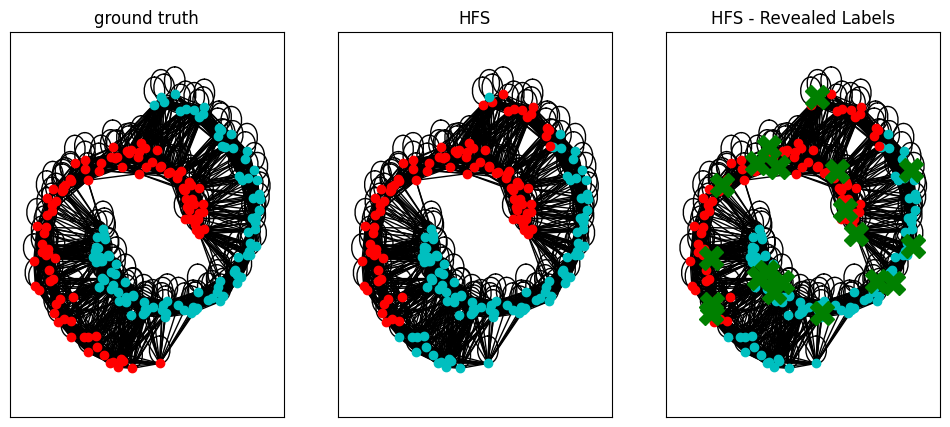

Soft=False, Accuracy=0.865


In [5]:
params["k"] = 27
params["laplacian_normalization"] = "rw"

seed = 42
X, Y, hard_labels, hard_accuracy = two_moons_hfs(
    l=10,
    l_noisy=0,
    soft=False,
    dataset="data_2moons_hfs.mat",
    plot=True,
    seed=seed,
    **params
)


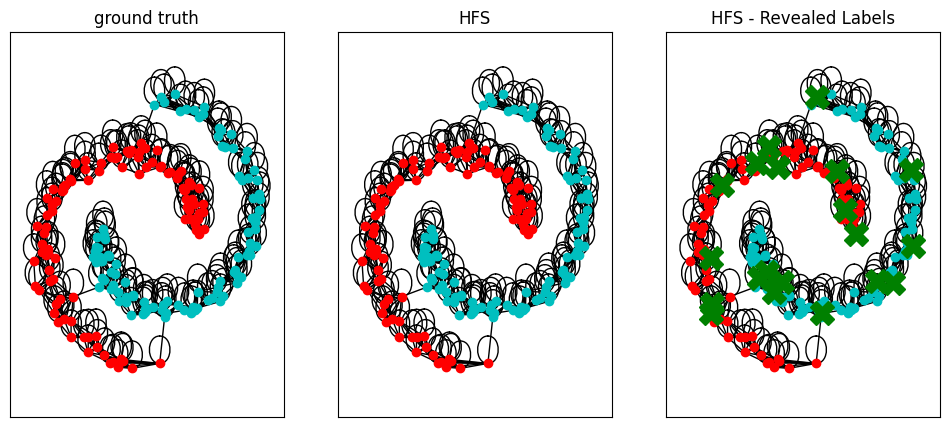

Soft=False, Accuracy=1.0


In [6]:
seed = 42
params['k'] = 8
X, Y, hard_labels, hard_accuracy = two_moons_hfs(l=10, l_noisy=0, soft=False, dataset='data_2moons_hfs.mat',
                                                 plot=True, seed=seed, **params)

### Question 1.2  - Using `data_2moons_hfs_large.mat`, run `two_moons_hfs` several times with l=4. What can go wrong?

* Tips:
    * When running `two_moons_hfs` several times, don't forget to set `seed=None`

In [7]:
# np.random.seed(42)
for ii in range(20):
    X, Y, hard_labels, hard_accuracy = two_moons_hfs(l=4, l_noisy=0, soft=False, 
                                                     dataset='data_2moons_hfs_large.mat',
                                                     plot=False, seed=None, **params)
    
#mask_labels?  # check parameters

Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0


If there are too few labels in our dataset, the ``mask_labels`` function can hide all the labels except one, therefore there will be just one label and our model will always output that label, which is a problem. Fortunately, we receive the following error: "AssertionError: only one class in training data!". To solve this issue, we have to set the parameter ``per_class`` to ``True``.

We always get 100% accuracy with the hard HFS method. But, if we add some noisy labels, the accuracy goes down.

### Question 1.3 - Using `data_2moons_hfs.mat`, l=10 and l_noisy=5, compare hard HFS to soft HFS. Report the accuracy and comment the results.

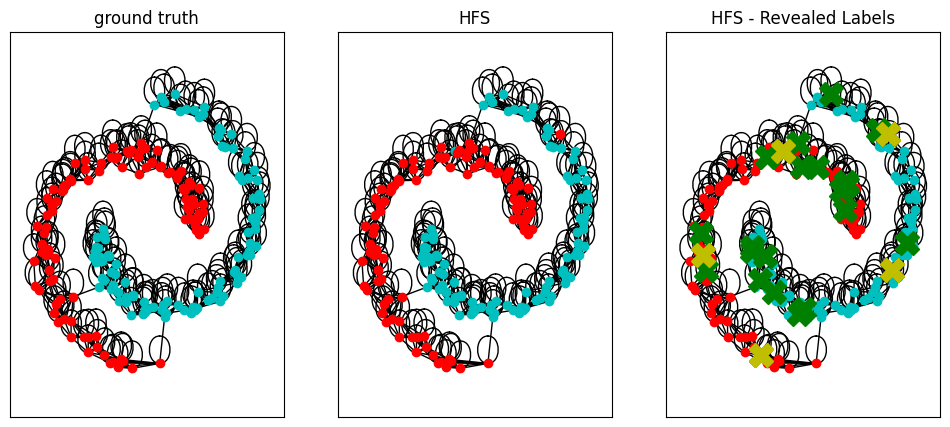

Soft=False, Accuracy=0.99


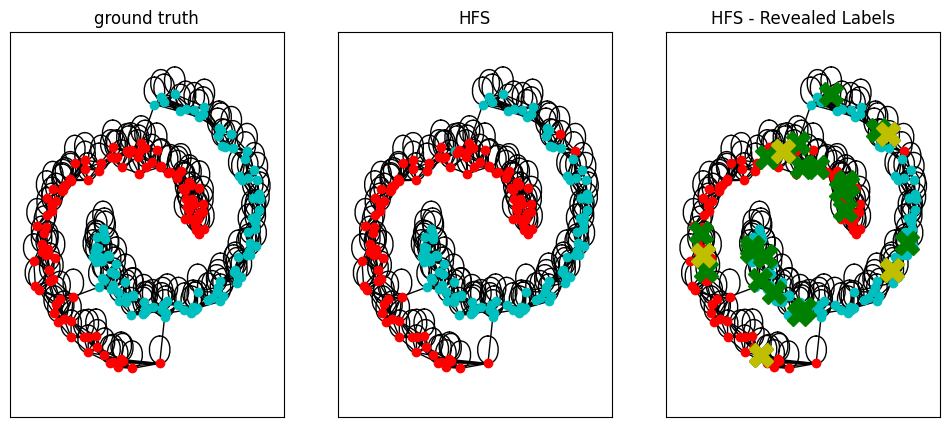

Soft=True, Accuracy=0.985


In [8]:
# Comparing
seed = 5  # To run several times with random outcomes, set seed=None. Otherwise, set a seed for reproducibility.
plot = True 
dataset = 'data_2moons_hfs.mat' # Try also 'data_2moons_hfs_large.mat'

X, Y, hard_labels, hard_accuracy = two_moons_hfs(l=10, l_noisy=5, soft=False, dataset=dataset,
                                                 plot=plot, seed=seed, **params)

params["c_l"] = 1
params["c_u"] = 0.1
X, Y, soft_labels, soft_accuracy = two_moons_hfs(l=10, l_noisy=5, soft=True, dataset=dataset,
                                                 plot=plot, seed=seed, **params)

In [9]:
# Comparing
seed = None  # To run several times with random outcomes, set seed=None. Otherwise, set a seed for reproducibility.
plot = False 
dataset = 'data_2moons_hfs.mat' # Try also 'data_2moons_hfs_large.mat'

hard_accuracy_mean = 0
soft_accuracy_mean = 0
for _ in range(100):
    X, Y, hard_labels, hard_accuracy = two_moons_hfs(l=10, l_noisy=5, soft=False, dataset=dataset,
                                                     plot=plot, seed=seed, **params)
    
    hard_accuracy_mean += hard_accuracy
    
    params["c_l"] = 0.95
    params["c_u"] = 0.1
    X, Y, soft_labels, soft_accuracy = two_moons_hfs(l=10, l_noisy=5, soft=True, dataset=dataset,
                                                     plot=plot, seed=seed, **params)
    
    soft_accuracy_mean += soft_accuracy
    
print("Mean Hard accuracy: ", hard_accuracy_mean / 100)
print("Mean Soft accuracy: ", soft_accuracy_mean / 100)

Soft=False, Accuracy=0.995
Soft=True, Accuracy=0.85
Soft=False, Accuracy=0.875
Soft=True, Accuracy=0.985
Soft=False, Accuracy=0.855
Soft=True, Accuracy=0.83
Soft=False, Accuracy=0.945
Soft=True, Accuracy=0.93
Soft=False, Accuracy=0.985
Soft=True, Accuracy=0.945
Soft=False, Accuracy=0.98
Soft=True, Accuracy=0.9
Soft=False, Accuracy=0.93
Soft=True, Accuracy=0.99
Soft=False, Accuracy=0.97
Soft=True, Accuracy=0.965
Soft=False, Accuracy=0.94
Soft=True, Accuracy=0.925
Soft=False, Accuracy=0.995
Soft=True, Accuracy=0.99
Soft=False, Accuracy=0.99
Soft=True, Accuracy=0.96
Soft=False, Accuracy=0.955
Soft=True, Accuracy=0.955
Soft=False, Accuracy=0.995
Soft=True, Accuracy=0.885
Soft=False, Accuracy=0.92
Soft=True, Accuracy=0.885
Soft=False, Accuracy=0.92
Soft=True, Accuracy=0.96
Soft=False, Accuracy=0.85
Soft=True, Accuracy=1.0
Soft=False, Accuracy=0.93
Soft=True, Accuracy=0.985
Soft=False, Accuracy=0.995
Soft=True, Accuracy=0.885
Soft=False, Accuracy=0.91
Soft=True, Accuracy=0.98
Soft=False, Acc

Both the hard and soft versions of the algorithm achieve over 90% accuracy, demonstrating the effectiveness of HFS in both forms. However, on average, the soft version performs better. This is because, in situations with noisy labels, the hard version struggles more because of the hard constraint $f(x_i) = y_i$. Indeed, then, the method try to learn based on these noisy labels. 

## 2. Face recognition with HFS

Now, we apply HFS to the task of face recognition, that is, our goal is to classify faces as belonging to different people. Since faces all share common features, it can be a good idea to leverage a large quantity of unlabeled data to improve classification accuracy. In this part of the exercise, you will:

* Extract faces from the images using OpenCV for face detection, and use the same library to apply preprocessing steps;
* Run HFS for classification.

### Implementation

Choose the hyperparameters and run HFS for face recognition, using both the small and large dataset. You can try to change the preprocessing steps (e.g. equalizeHist, GaussianBlur) applied to the images.

**Important**: make sure your HFS code is able to handle more than two classes!

In [10]:
import matplotlib.pyplot as plt
from imageio import imread
import numpy as np
import cv2
import os

from load_images import load_image_data, plot_image_data
from load_images import load_image_data_augmented, plot_image_data_augmented

### Question 2.1 - How did you manage to label more than two classes?



To manage more than 2 classes, f is a represented by a matrix $\in \mathbb{R}^{N \times N_{classes}}$ where $N$ is the number of data points and $N_{classes}$ is the number of classes. In this matrix each row $i$ correspond to the respective probabilities that the data point $i$ belong to the class number $j$ where $j$ is the index of the columns. Then, to choose the class of the data point we just compute $(\arg \max_{j \in 0, \cdots, N_{classes} - 1} f[:,j]) + 1$.

### Question 2.2 - Report the best accuracy you obtained for both (small and augmented) datasets.

* Tips:
    * The small dataset (10 images per person) is loaded with `load_image_data`.
    * Use `load_image_data_augmented` for the augmented dataset (50 images per person). 

In [11]:
"""
Define parameters for face recognition with HFS
"""
params_face_rec = {}
params_face_rec['laplacian_regularization'] = 1.0
params_face_rec['var'] = 10000.0
params_face_rec['eps'] = None
params_face_rec['k'] = 20
params_face_rec['laplacian_normalization'] = 'unn'
params_face_rec['c_l'] = 0.9
params_face_rec['c_u'] = 0.1

In [12]:
# Function to preprocess the images
# You may try to change it and check the impact on the classification accuracy
def preprocess_image(image):
    """
    Parameters
    ----------
    image : array
        (width, height) array representing a grayscale image
    
    Returns
    -------
        (96, 96) preprocessed image
    """
    output_frame_size = 96   # do not change the output frame size!
    image = cv2.bilateralFilter(image, 9, 75, 75)
    image = cv2.equalizeHist(image)
    image = cv2.GaussianBlur(image, (5, 5), 0)
    im = cv2.resize(image, (output_frame_size, output_frame_size)).astype(np.float64)
    im -= im.mean()
    im /= im.max()
    image = im
    return image

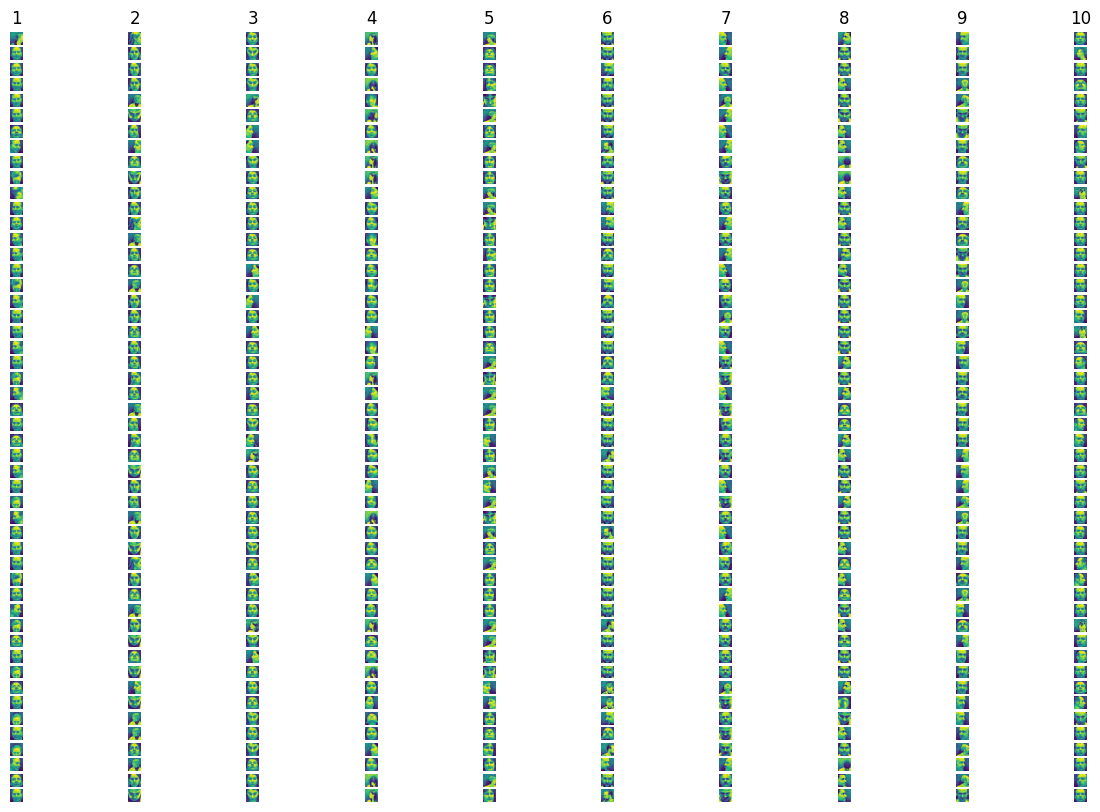

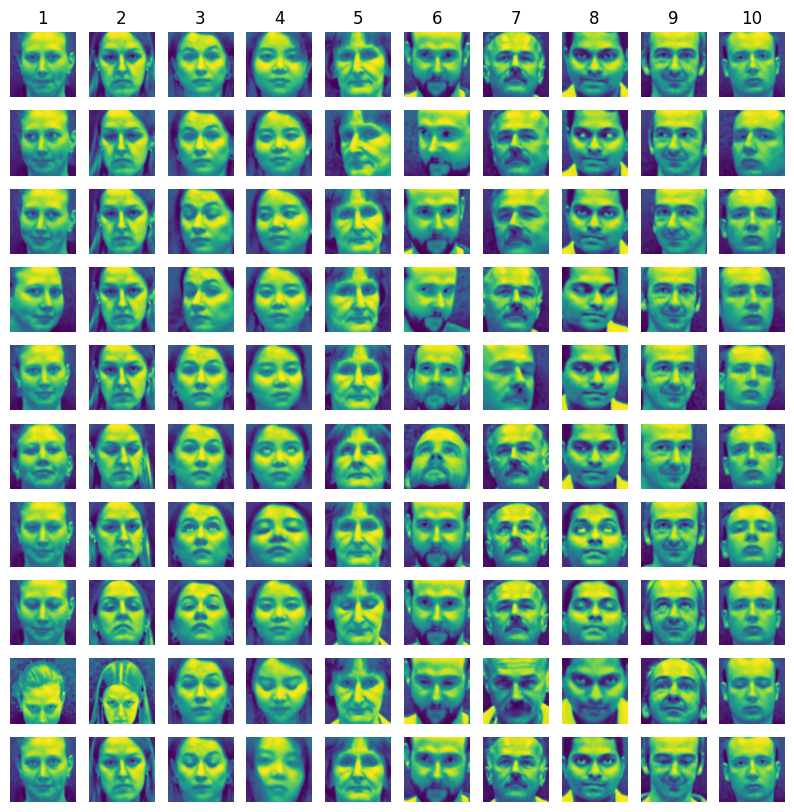

In [13]:
# 10 images per person
np.random.seed(456)   # set seed, since labels are masked randomly
images, labels, masked_labels = load_image_data(preprocess_image)

# 50 images per person
images_a, labels_a, masked_labels_a = load_image_data_augmented(preprocess_image)
plot_image_data_augmented(images_a)

# uncomment below if you want to visualize the images
plot_image_data(images)
#print(images.shape)
#print(masked_labels.reshape(-1, 10))

In [14]:
def grid_search(images, masked_labels, labels, params):
    best_accuracy = 0.0
    best_params = {}

    params_face_rec = {}
    params_face_rec["eps"] = None
    
    for laplacian_regularization in params["laplacian_regularization"]:
        params_face_rec["laplacian_regularization"] = laplacian_regularization

        for laplacian_normalization in params["laplacian_normalization"]:
            params_face_rec["laplacian_normalization"] = laplacian_normalization

            for k in params["k"]:
                params_face_rec["k"] = k

                for var in params["var"]:
                    params_face_rec["var"] = var

                    for c_l in params["c_l"]:
                        params_face_rec["c_l"] = c_l
                        params_face_rec["c_u"] = 1 - c_l

                        L = build_laplacian_regularized(
                            images, 
                            params_face_rec['laplacian_regularization'], 
                            params_face_rec['var'], 
                            params_face_rec['eps'], 
                            params_face_rec['k'], 
                            params_face_rec['laplacian_normalization']
                        )
                        predicted_labels, _ = compute_hfs(L, masked_labels, soft=True, **params_face_rec)
                        accuracy = np.equal(predicted_labels, labels).mean()

                        if accuracy > best_accuracy:
                            best_accuracy = accuracy
                            best_params = dict(params_face_rec)

    return best_params, best_accuracy

In [15]:
params = {
    "laplacian_regularization": [0.1, 0.4, 1.0],
    "var": [100000, 10000, 1000, 100],
    "k": [4, 10, 20, 50],
    "c_l": [0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99],
    "laplacian_normalization": ["unn", "rw", "sym"]
}
best_params, best_accuracy = grid_search(images, masked_labels, labels, params)

In [16]:
best_params

{'eps': None,
 'laplacian_regularization': 0.1,
 'laplacian_normalization': 'unn',
 'k': 10,
 'var': 100,
 'c_l': 0.9,
 'c_u': 0.09999999999999998}

In [17]:
{'eps': None,
 'laplacian_regularization': 0.1,
 'laplacian_normalization': 'unn',
 'k': 10,
 'var': 100,
 'c_l': 0.9,
 'c_u': 0.09999999999999998}

{'eps': None,
 'laplacian_regularization': 0.1,
 'laplacian_normalization': 'unn',
 'k': 10,
 'var': 100,
 'c_l': 0.9,
 'c_u': 0.09999999999999998}

In [18]:
# graph Laplacian
L = build_laplacian_regularized(images, 
                                best_params['laplacian_regularization'], 
                                best_params['var'], 
                                best_params['eps'], 
                                best_params['k'], 
                                best_params['laplacian_normalization'])

Accuracy 10 images per person=  0.84


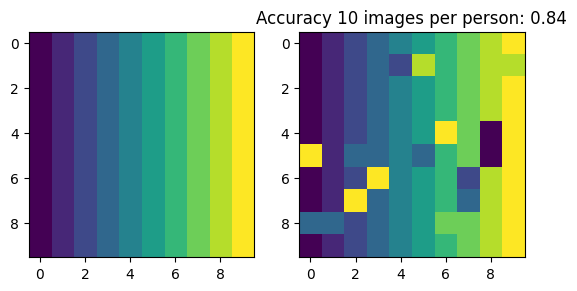

In [19]:
# Run HFS
predicted_labels, f = compute_hfs(L, masked_labels, soft=True, **best_params)
accuracy = np.equal(predicted_labels, labels).mean()
print("Accuracy 10 images per person= ", accuracy)

# Visualize predicted vs true labels
plt.subplot(121)
plt.imshow(labels.reshape((-1, 10)))
plt.subplot(122)
plt.imshow(predicted_labels.reshape((-1, 10)))
plt.title("Accuracy 10 images per person: {}".format(accuracy))
plt.show()

In [20]:
(masked_labels == 0).sum()/100

np.float64(0.6)

In [21]:
(masked_labels_a == 0).sum()/500

np.float64(0.92)

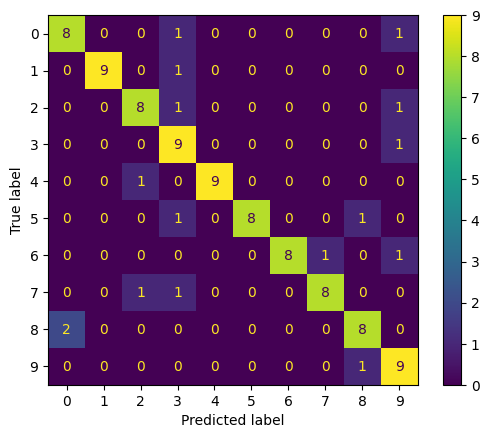

In [22]:
cm = confusion_matrix(labels, predicted_labels)
display = ConfusionMatrixDisplay(confusion_matrix=cm)
display.plot()
plt.show()

In [23]:
# graph Laplacian
L_a = build_laplacian_regularized(images_a, 
                                best_params['laplacian_regularization'], 
                                best_params['var'], 
                                best_params['eps'], 
                                best_params['k'], 
                                best_params['laplacian_normalization'])

Accuracy 50 images per person=  0.624


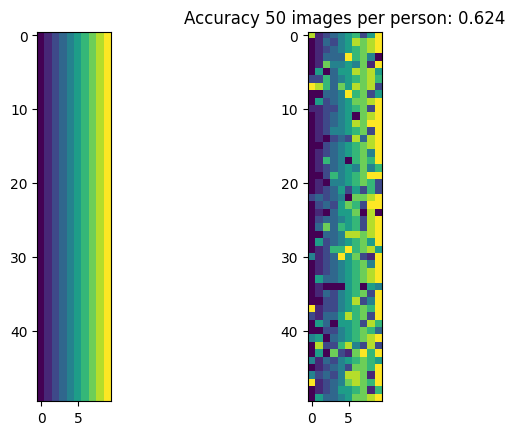

In [24]:
# Run HFS
predicted_labels_a, f_a = compute_hfs(L_a, masked_labels_a, soft=True, **best_params)
accuracy_a = np.equal(predicted_labels_a, labels_a).mean()
print("Accuracy 50 images per person= ", accuracy_a)

# Visualize predicted vs true labels
plt.subplot(121)
plt.imshow(labels_a.reshape((-1, 10)))
plt.subplot(122)
plt.imshow(predicted_labels_a.reshape((-1, 10)))
plt.title("Accuracy 50 images per person: {}".format(accuracy_a))
plt.show()

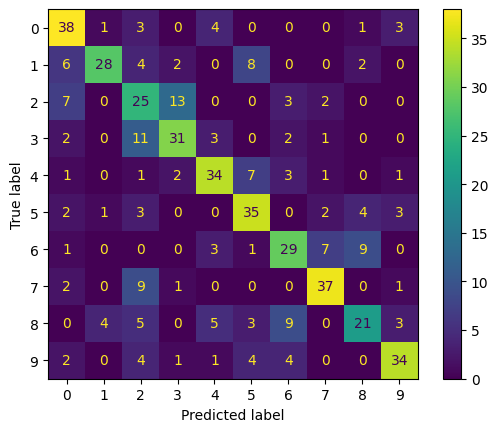

In [25]:
cm_a = confusion_matrix(labels_a, predicted_labels_a)
display_a = ConfusionMatrixDisplay(confusion_matrix=cm_a)
display_a.plot()
plt.show()

By choosing the following parameters after doing a grid_search to find the best accuracy:
- eps = None
- laplacian_regularization = 0.1
- laplacian_normalization = unn
- k = 10,
- var = 100
- c_l = 0.9
- c_u =  0.09999999999999998

We obtain the following accuracies:
- on the 10 images per person dataset: 0.84
- on the 10 images per person dataset: 0.62



### Question 2.3 - If the accuracy changes when using the augmented dataset, explain why. Does using additional data always increase the performance?

The change in accuracy when using the augmented dataset can be influenced by multiple factors. Although it is generally assumed that adding more data improves performance, the reality is more complex.

Increasing the number of images per person from 10 to 50 in the augmented dataset doesn't automatically ensure better accuracy. The impact of additional data depends on aspects like the quality, diversity, and relevance of the data to the task. In some cases, dataset augmentation may introduce noise or unnecessary variations, which can result in a reduction in accuracy instead of an improvement. 

In the end, the performances using the augmented dataset didn't benefit the augmentation at all: the performances are much worse. This could be explained by several things:
- The small dataset has 4 labels per class, the rest is unlabeled. Therefore, there is 60% of unlabeled data. For the bigger dataset there is still labels per class, but this time we have 50 images per class instead of 10. Then, for the big dataset there is 92% of unlabeled data. The ratio of unlabeled data is too important for the bigger dataset. Indeed, the information from the labeled data can't be well enough be propagated in the graph as the faces are not easily separable.
- In the augmented dataset, some images are really hard to be classified, indeed some of the images are faces in profile which are hard to classify instead of only faces from front in the small dataset. This makes solving the classifying task harder. 

## 3. Online SSL

Now, instead of having all the data available at once, images will be received online: at each time $t$, a new image $x_t$ is observed and the algorithm has to output a label $y_t$. 

Use the function `create_user_profile` to capture a training set of labeled data (of your face and someone else). The faces will be preprocessed and saved in the folder `data/faces`. They will be loaded by `online_face_recognition`.


### Implementation

Choose the hyperparameters and complete the functions `online_ssl_update_centroids` and `online_ssl_compute_solution`. 

Modify your code to be able to disregard faces it cannot recognize.

* Tips:
    * You can use the functions `build_similarity_graph` and `build_laplacian`.

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import os
import sys
from scipy.spatial import distance
import scipy.io as sio

from helper_online_ssl import create_user_profile, online_face_recognition
from helper import build_similarity_graph, build_laplacian

In [27]:
#create_user_profile('Martin')

In [28]:
#create_user_profile('Delphine')

In [29]:
"""
Define parameters for face recognition with HFS
"""
params_online_ssl = {}
params_online_ssl['laplacian_regularization'] = 1
params_online_ssl['var'] = 10
params_online_ssl['eps'] = None
params_online_ssl['k'] = 10
params_online_ssl['laplacian_normalization'] = 'rw'
params_online_ssl['c_l'] = 0.95
params_online_ssl['c_u'] = 0.01

In [30]:
class IncrementalKCenters:
    def __init__(self, labeled_faces, labels, label_names, max_num_centroids=50, classify_new_classes = False):
        self.classify_new_classes = classify_new_classes   
        #  Number of labels
        self.n_labels = max(labels)
        
        #  Dimension of the input image
        self.image_dimension = labeled_faces.shape[1]

        #  Check input validity
        assert (set(labels) == set(
            range(1, 1 + self.n_labels))), "Initially provided faces should be labeled in [1, max]"
        assert (len(labeled_faces) == len(labels)), "Initial faces and initial labels are not of same size"

        #  Number of labelled faces
        self.n_labeled_faces = len(labeled_faces)

        # Model parameter : number of maximum stored centroids
        self.max_num_centroids = max_num_centroids

        # Model centroids (inital labeled faces). Shape = (number_of_centroids, dimension)
        self.centroids = labeled_faces

        # Centroids labels
        self.Y = labels
        
        # Label names (= user names)
        self.label_names = label_names

        # Variables that are initialized in online_ssl_update_centroids()
        self.centroids_distances = None
        self.taboo = None
        self.V = None
        self.init = True

        # index of x_t (initialized later)
        self.last_face = None
    
    def initialize(self):
        """
        Initialization after the first time that the maximum number of centroids is reached.
        """       
        #  Compute the centroids distances
        self.centroids_distances = distance.cdist(self.centroids, self.centroids)

        #  set labeled nodes and self loops as infinitely distant, to avoid merging labeled centroids
        np.fill_diagonal(self.centroids_distances, +np.inf)
        self.centroids_distances[0:self.n_labeled_faces, 0:self.n_labeled_faces] = +np.inf

        # put labeled nodes in the taboo list
        self.taboo = np.array(range(self.centroids.shape[0])) < self.n_labeled_faces

        # initialize multiplicity
        self.V = np.ones(self.centroids.shape[0])


    def online_ssl_update_centroids(self, face):
        """
        TO BE COMPLETED

        Update centroids, multiplicity vector V, labels Y.
        
        Note: In Y, set label to 0 for unlabeled faces.

        Parameters
        ----------
        face : array
            New sample
        
        Returns
        --------
        List with the scores for each possible label:
            [(label_1, score_1), (label_2, score_2), ...]
        """

        assert (self.image_dimension == len(face)), "new image not of good size"

        # Case 1: maximum number of centroids has been reached.
        if self.centroids.shape[0] >= self.max_num_centroids + 1:
            if self.init:
                #  Initialization after the first time that the maximum number of centroids is reached
                self.initialize()
                self.init = False
            """
            Find c_rep and c_add following Algorithm 1.
            
            - c_1, c_2 = two closest centroids (minimum distance) such that at least one of them is not in self.taboo.
            - c_rep = centroid in {c_1, c_2} that is in self.taboo. If none of them is in self.taboo, c_rep is the one
                      with largest multiplicity.
            - c_add = centroid in {c_1, c_2} that is not c_rep.
            """
 
            n_centroids = self.centroids_distances.shape[0]            
            argsort = np.argsort(self.centroids_distances.ravel())
            for idx in argsort:
                c_1 = idx // n_centroids
                c_2 = idx % n_centroids
                if c_1 not in self.taboo or c_2 not in self.taboo:
                    break
        
            if c_1 in self.taboo:
                c_rep = c_1
                c_add = c_2
            elif c_2 in self.taboo:
                c_rep = c_2
                c_add = c_1
            elif self.V[c_2] <= self.V[c_1]:
                c_rep = c_1
                c_add = c_2
            else:
                c_rep = c_2
                c_add = c_1

            """
            Update data structures: self.centroids and self.V
            """
            #classify new classes (recurrent faces)
            if self.classify_new_classes:
                #if an unlabeled face has been seen multiples times we label it
                if c_rep not in self.taboo and self.V[c_rep] > 15:
                    self.taboo[c_rep] = True
                    self.taboo[c_add] = True
                    new_label = np.max(self.Y) + 1
                    self.Y[c_rep] = new_label
                    self.Y[c_add] = new_label
                    self.label_names += [f"Person {new_label}"]
                    self.n_labeled_faces += 1
                    self.n_labels += 1
                
                #otherwise we just do a classical update  
                else:
                    self.V[c_rep] = self.V[c_rep] + self.V[c_add]
                
                self.centroids[c_add, :] = face
                self.V[c_add] = 1
            
            #classical update
            else:
                self.V[c_rep] = self.V[c_rep] + self.V[c_add]
                self.centroids[c_add, :] = face
                self.V[c_add] = 1

            """
            Update the matrix containing the distances.
            """
            dist_row = distance.cdist(np.array([self.centroids[c_add]]), self.centroids)[0]
            dist_row[c_add] = +np.inf
            self.centroids_distances[c_add, :] = dist_row
            self.centroids_distances[:, c_add] = dist_row
            self.last_face = c_add

        # Case 2: create new centroid with face
        # Remark: the multiplicities vector self.V is initialized in self.initialize()
        else:
            current_len = len(self.centroids)
            self.Y = np.append(self.Y, 0)
            self.centroids = np.vstack([self.centroids, face])

    def online_ssl_compute_solution(self):
        """
        TO BE COMPLETED.

        Returns a prediction corresponding to self.last_face.
        """

        # Multiplicity matrix
        if self.init:
            V = np.diag(np.ones(self.centroids.shape[0]))
            self.last_face = self.centroids.shape[0] - 1
        else:
            V = np.diag(self.V)
            
        # Build quantized graph and its regularized Laplacian
        
        W = build_similarity_graph(
            self.centroids, 
            var = params_online_ssl['var'],
            eps = params_online_ssl['eps'],
            k = params_online_ssl['k']
        )
        L = build_laplacian(V @ W @ V, params_online_ssl['laplacian_normalization'])
        Q = L + params_online_ssl['laplacian_regularization']*np.eye(W.shape[0])   # regularized Laplacian
        
        # Compute the hard HFS solution f.
        labels, f = compute_hfs(Q, self.Y, soft=False, **params_online_ssl)

        # Return the score for each possible label
        num_classes = len(np.unique(self.Y))-1 
        label_scores = []
        for ii in range(num_classes):
            label = self.label_names[ii]
            score = f[self.last_face, ii]
            label_scores.append((label, score))
        
        # handle unknown faces
        label_scores = [label_score for label_score in label_scores if label_score[1] > 1e-80] #My scores are very low...
        if len(label_scores) == 0:
            label_scores = [("Unknown", 1)]

        return label_scores

### Question 3.1 - Attach to this notebook some of the resulting frames of online face recognition. 

* Tips: 
    * You can save the resulting frame and add it to the notebook in a markdown cell as `![title](picture.png)`

In [31]:
online_face_recognition(['Martin', 'Delphine'], IncrementalKCenters, n_pictures=11)

Profile found with 11 images.
Profile found with 11 images.


KeyboardInterrupt: 

I was recognised as we can see from the following screenshots (however it seems I have a problem with the score which is very low):

![title](martin-1.png)

![title](martin-2.png)


![title](martin-3.png)

Here, my mom is recognised correctly as well (same problem of low score).

![title](delphine-1.png)


The performances are already good! However, this method seems to be not very robust. Indeed, moving faces are less likely to be recognised (due to OpenCV), sometimes some bounding boxes appears to a place which doesn't correspond to a face and vice versa. Moreover, the recognition seems to be highly dependent on the position of the face, the light and the background.


    
### Question 3.2 - What strategy did you use to label a face as unknown? Attach to this notebook an example of a unknown face being correctly labeled as unknown.

* Tips
    * If you identify a face as unknown, you can return `[("unknown", score)]` from the function `online_ssl_compute_solution`.


To label a face as unknown, I used a threshold method. I only keep the tuples (label, score) such that $score > threshold$, then if I can't keep any tuples from the known labels, then I classify the face as unknown with a score of 1. I determined the threshold experimentally.

Here, the other person in the vision field of the camera is given the "unknown" profile. (It's a magnet with a portrait paint by Théodore Géricault) 

![title](martin-paint-1.png)


![title](martin-paint-2.png)


### Question 4.1 - You can now classify faces as either known (i.e. belong to a class) or unknown (i.e. belong to no class). How would you modify the algorithm to automatically learn to classify new classes? That is, how can you modify the algorithm so that faces that appear unfrequently are labeled as unknown, but once a specific face has been seen enough times it gets assigned an automatic label (e.g. AutoBob) and from that point it is treated as a new class. 

* Tips: 
    * Think back to the idea of incremental clustering as unsupervised classification

In [32]:
online_face_recognition(['Martin', 'Delphine'], IncrementalKCenters, n_pictures=11, classify_new_classes = True)

Profile found with 11 images.
Profile found with 11 images.


KeyboardInterrupt: 

![title](new-class-paint.png)

Initially, unfamiliar faces are labeled as "unknown." If a face appears frequently (more than 15 times), the system assigns it a new label (e.g., "Person 1") and starts treating it as a known face. It tracks how often faces appear and updates their representations. If a face hasn't been seen enough, it stays "unknown" until it reaches the threshold. In short, the system gradually creates new labels for frequently seen faces while keeping infrequent faces unlabeled.

This method works, but there are some drawbacks. Indeed, labeled faces cannot be recognised and be treated as unknown and therefore the algorithm can create a new class for an already labeled face.


    
### Question 4.2 - In class we considered different kinds of metric for (semi) supervised learning. Looking at the face classification task, try to quantify how the offline-online, exact-quantized, and inductive-transductive axes influence each other. In particular given $l$ labeled faces, $u = N - l$ unlabeled faces, and $m$ extra/test faces design an experimental study to quantify these trade-offs, both in terms of transductive and inductive error, as well as online/batch error. Examples of combinations that can be used to study these axes are:
* Supervised vs Semi-supervised
    * A comparison between a supervised learner (of your choice) trained on the $l$ labeled faces and a semi-supervised learner (of your choice) trained on the $l + u$ labeled and unlabeled faces
    * A comparison between a supervised learner (of your choice) trained on the $N$ labeled and unlabeled (you reveal everything here) faces and a semi-supervised learner (of your choice) trained on the $l + u$ labeled and unlabeled faces.
* Inductive vs Transductive
    * A comparison between a supervised learner (of your choice) trained on the $l$ labeled faces and a semi-supervised learner (of your choice) trained on the $l + u$ labeled and unlabeled faces evaluated on the $N$ revealed points and then on the $m$ unrevealed points.
* Supervised vs Semi-supervised and Inductive vs Transductive
    * A comparison between a supervised learner (of your choice) trained on the $N$ labeled and unlabeled (you reveal everything here) faces and a semi-supervised learner (of your choice) trained on the $l + u$ labeled and unlabeled faces, evaluated on the $N$ revealed points and then on the $m$ unrevealed points.
* Online vs Batch
    * A comparison between a supervised learner (of your choice) trained on the $N$ labeled faces and an online supervised learner (of your choice) trained revealing the $N$ labels one at a time
* Exact vs Quantized
    * A comparison between a semi-supervised learner (of your choice) trained on the $N$ labeled and unlabeled (you reveal everything here) faces using a certain memory budget, and the same learner with a constrained memory budget.
* Exact vs Quantized and Online vs Batch and Inductive vs Transductive
    * A comparison between a semi-supervised online learner (of your choice) trained with and without quantization, evaluated both on the $N$ faces revealed during training, and $m$ faces unrevealed. You can further compare the online performance of the learner against the performance of an "hindsight" learner that saw the labels all at once

Supervised Learning (SL) VS Semi supervised Learning (SSL)

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

def supervised_vs_semi_supervised(X, Y, l, params, seed=None):
    """
    Compare supervised and semi-supervised learning on the given dataset.
    
    Parameters:
    -----------
    X : The dataset features.
    Y : The dataset labels.
    l : Number of labeled examples.
    params : Parameters for building the graph Laplacian and HFS.
    seed : Random seed for reproducibility.
    Returns:
    --------
    Accuracy of supervised and semi-supervised methods.
    """
    if seed is not None:
        np.random.seed(seed)

    #mask labels
    Y_masked = mask_labels(Y, l, per_class=True)

    #supervised learner (uses only labeled data)
    labeled_idx = np.where(Y_masked != 0)[0]
    X_labeled = X[labeled_idx]
    Y_labeled = Y[labeled_idx]
    
    #evaluate supervised learner on the labeled set
    #classifier = LogisticRegression(penalty='l2', C = 10, random_state=seed)
    classifier = SVC(C=0.025, random_state=42)
    classifier.fit(X_labeled, Y_labeled)
    labels_supervised = classifier.predict(X)
    accuracy_supervised = np.mean(labels_supervised == Y)
    
    #semi-supervised learner (uses both labeled and unlabeled data)
    L_semi_supervised = build_laplacian_regularized(X, params['laplacian_regularization'],
                                                    var=params['var'], eps=params['eps'],
                                                    k=params['k'], laplacian_normalization=params['laplacian_normalization'])
    
    labels_semi_supervised, _ = compute_hfs(L_semi_supervised, Y_masked, soft=False, **params)
    accuracy_semi_supervised = np.mean(labels_semi_supervised == Y)
    
    print(f"Supervised Accuracy (on {l} labeled samples): {accuracy_supervised}")
    print(f"Semi-supervised Accuracy (on {l} labeled and {len(Y) - l} unlabeled samples): {accuracy_semi_supervised}")
    
    return accuracy_supervised, accuracy_semi_supervised

params = {
    'laplacian_regularization': 0.1,
    'var': 1.0,
    'eps': None,
    'k': 10,
    'laplacian_normalization': 'rw',
    'c_l': 0.9,
    'c_u': 0.1
}

images, labels, masked_labels = load_image_data(preprocess_image)

In [34]:
accuracy_supervised_list = []
accuracy_semi_supervised_list = []
for i in range(1, 11):
    accuracy_supervised, accuracy_semi_supervised = supervised_vs_semi_supervised(images, labels, l=i, params=params, seed=42)
    accuracy_supervised_list.append(accuracy_supervised)
    accuracy_semi_supervised_list.append(accuracy_semi_supervised)

Supervised Accuracy (on 1 labeled samples): 0.45
Semi-supervised Accuracy (on 1 labeled and 99 unlabeled samples): 0.32
Supervised Accuracy (on 2 labeled samples): 0.68
Semi-supervised Accuracy (on 2 labeled and 98 unlabeled samples): 0.46
Supervised Accuracy (on 3 labeled samples): 0.76
Semi-supervised Accuracy (on 3 labeled and 97 unlabeled samples): 0.61
Supervised Accuracy (on 4 labeled samples): 0.82
Semi-supervised Accuracy (on 4 labeled and 96 unlabeled samples): 0.74
Supervised Accuracy (on 5 labeled samples): 0.85
Semi-supervised Accuracy (on 5 labeled and 95 unlabeled samples): 0.8
Supervised Accuracy (on 6 labeled samples): 0.84
Semi-supervised Accuracy (on 6 labeled and 94 unlabeled samples): 0.84
Supervised Accuracy (on 7 labeled samples): 0.87
Semi-supervised Accuracy (on 7 labeled and 93 unlabeled samples): 0.88
Supervised Accuracy (on 8 labeled samples): 0.88
Semi-supervised Accuracy (on 8 labeled and 92 unlabeled samples): 0.91
Supervised Accuracy (on 9 labeled samples

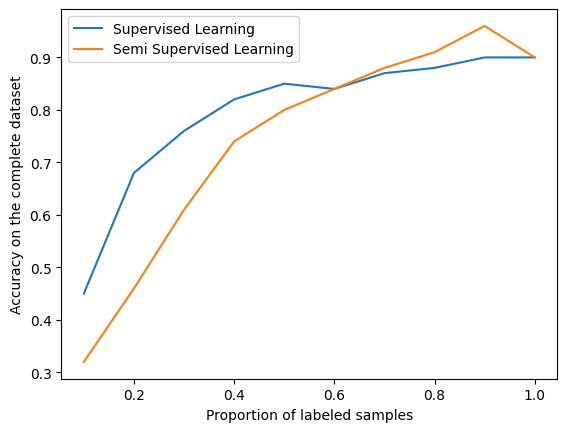

In [35]:
plt.plot(np.arange(0.1, 1.1, 1/len(accuracy_supervised_list)), accuracy_supervised_list, label="Supervised Learning")
plt.plot(np.arange(0.1, 1.1, 1/len(accuracy_supervised_list)), accuracy_semi_supervised_list, label="Semi Supervised Learning")
plt.xlabel("Proportion of labeled samples")
plt.ylabel("Accuracy on the complete dataset")
plt.legend()
plt.show()

From the plot, we can see that the semi-supervised learning (SSL) model performs better than the supervised learning (SL) model when there are some labeled and unlabeled data. Both models experience a decline in performance as the amount of missing data increases. This plot shows that the SSL model is able to effectively utilize the unlabeled data when the proportion of missing data is between 0% and 40%. However, after 40% of missing data, the gap performance of the SL model beat the performance of the SSL model, suggesting that there is too much unlabeled data for the SSL model to extract meaningful patterns.